In [1]:
sparkMemory = '1G'

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import os
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.window import Window
os.environ['PYSPARK_SUBMIT_ARGS'] = '--conf spark.drive.memory={} pyspark-shell'.format(sparkMemory)
spark = (SparkSession.builder.master("local[*]").getOrCreate())

## Clean up data

In [3]:
#Remove space in column while reading the data
data = (spark.read.option('header', 'true')
        .csv('data/DataSample.csv')
        .withColumnRenamed(' TimeSt', 'TimeSt'))

#Read poi while drop POI at same location
poi = (spark.read.option('header', 'true')
       .csv('data/POIList.csv')
       .select(
           F.col('POIID'),
           F.col(' Latitude').cast('float').alias('POI_Latitude'),
           F.col('Longitude').cast('float').alias('POI_Longitude'))
       .dropDuplicates(['POI_Latitude', 'POI_Longitude'])
      )

#Find suspicious ids
suspicious_ids = (data
                 .groupBy('TimeSt', 'Latitude', 'Longitude')
                 .agg(F.collect_set('_ID').alias('suspious_ids'))
                 .filter(F.size('suspious_ids')>1)
                 .select(F.explode('suspious_ids').alias('_ID')))

#Remove suspicious ids
data = (data
        .join(suspicious_ids, '_ID', 'left_anti')
        .withColumn('unix_time', F.unix_timestamp('TimeSt'))
        .withColumn('Latitude', F.col('Latitude').cast('float'))
        .withColumn('Longitude', F.col('Longitude').cast('float'))
        .repartition('_ID'))

## Label Data

In [4]:
#Find nearest POI for each data 
labelled = (data
            .crossJoin(F.broadcast(poi))
            .select('_ID', 'POIID',
                    F.sqrt(F.pow(F.col('Latitude')-F.col('POI_Latitude'), 2)
                           +F.pow(F.col('Longitude')-F.col('POI_Longitude'), 2))
                    .alias('distance')).rdd
            .map(lambda row: (row[0],(row[1], row[2])))
            .reduceByKey(lambda x,y: x if x[1]<y[1] else y)
            .map(lambda pair:[pair[0], pair[1][0], pair[1][1]])
            .toDF(['_ID', 'POIID', 'distance'])
            .repartition('_ID'))
data = data.join(labelled, '_ID')

## Analysis

we'd like to see statistics to see the characteristic of each POI

In [5]:
#Compute Distance statistics
poi_statistics = (data
                  .groupby('POIID')
                  .agg(F.mean('Latitude').alias('mean_lat'),
                       F.mean('Longitude').alias('mean_long'),
                       F.stddev('distance').alias('distance_stddev'), 
                       F.mean('distance').alias('distance_mean'), 
                       F.max('distance').alias('record_radius'),
                       F.count('_ID').alias('num_records')).cache())
poi_statistics_pd = poi_statistics.toPandas()
poi_statistics_pd

,POIID,mean_lat,mean_long,distance_stddev,distance_mean,record_radius,num_records
0,POI4,45.124196,-57.225898,27.334584,8.522389,192.704999,427
1,POI1,51.913549,-113.378075,3.849640,3.353111,24.851935,8725
2,POI3,44.237870,-78.767193,2.858711,5.537919,20.155376,8821


## Visualization of data

By plotting POI and data we can see most of the data reside in Canada, while some of them are localted in continents other than North America. Those points should be outliers since they are too far away from given POI.

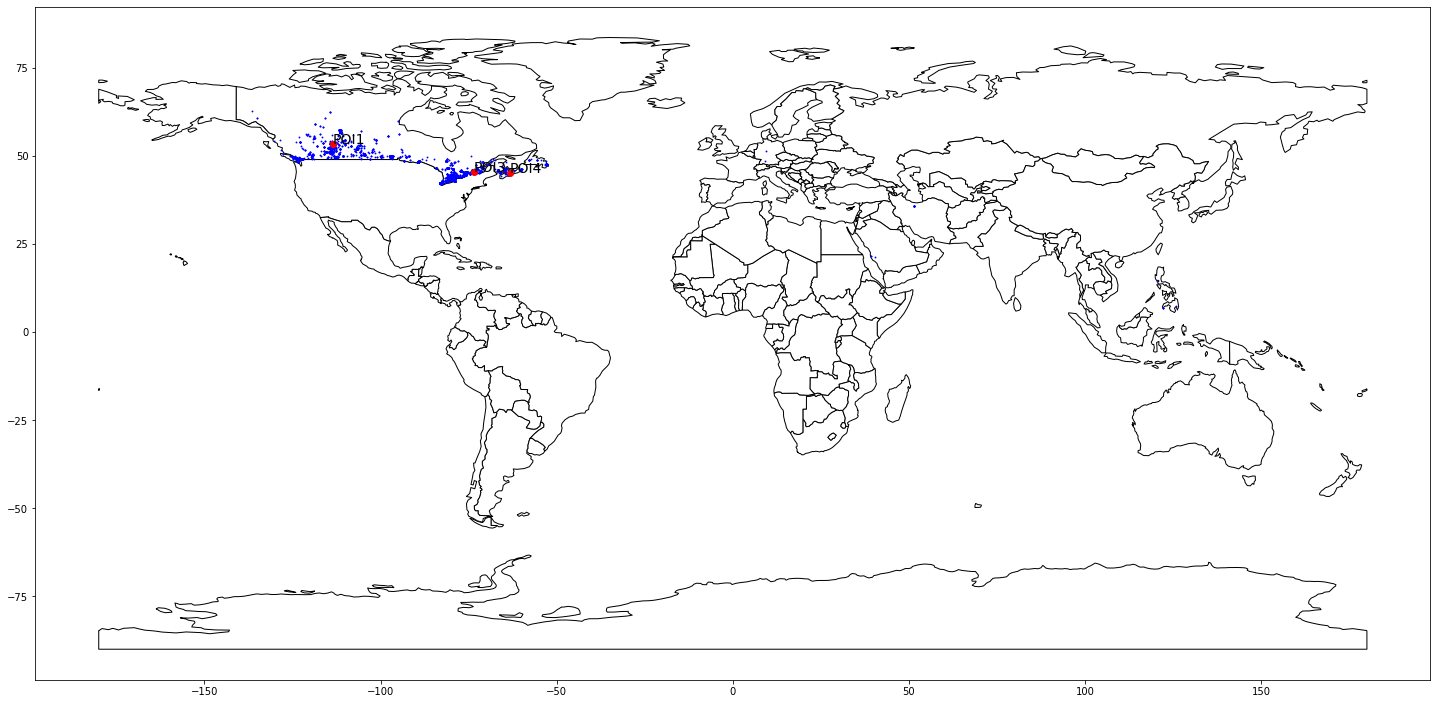

In [6]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
poi_pd = poi.toPandas()
poi_gdf = geopandas.GeoDataFrame(poi_pd, 
                             geometry=geopandas
                             .points_from_xy(poi_pd.POI_Longitude,
                                             poi_pd.POI_Latitude))
data_pd = data.toPandas()
data_gdf = geopandas.GeoDataFrame(data_pd, 
                       geometry=geopandas
                       .points_from_xy(data_pd.Longitude, 
                                       data_pd.Latitude))
#By this plot we can see there seems to be some outliers since they are not in North America
world = (geopandas
         .read_file(geopandas.datasets.get_path('naturalearth_lowres'))
         .rename(columns={'geometry': 'borders'})
         .set_geometry('borders'))
ax = world.plot(color='white', edgecolor='black', figsize=(25,25))
data_gdf.plot(ax=ax, color='blue', markersize=0.7)
poi_gdf.plot(ax=ax, color='red')
for triplets in poi_pd[['POI_Longitude', 'POI_Latitude', 'POIID']].to_numpy():
    ax.text(*triplets, fontsize=14)

## Removing Outliers and visualize
After removing outliers, we can plot different records labelled by their nearest POI and the circle based on farthest records. There are some overlap between regions of poi since the regoins are not circular.

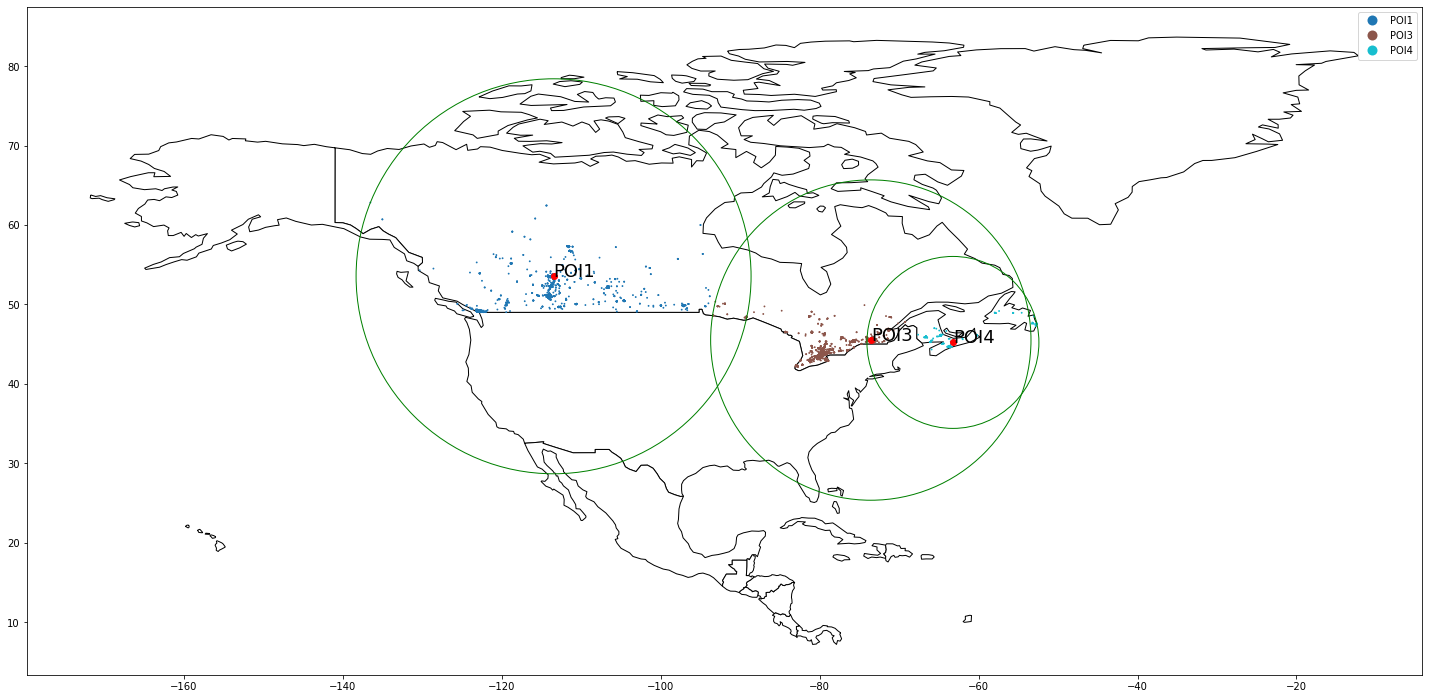

In [7]:
import numpy as np
data_location_gdf_clipped = geopandas.clip(data_gdf, world[world['name']=='Canada'])
ax = world[world['continent']=='North America'].plot(color='white', edgecolor='black', figsize=(25,25))
data_location_gdf_clipped.plot(ax=ax, column='POIID', markersize=0.7, legend=True)
poi_gdf.plot(ax=ax, color='red')
for triplets in poi_pd[['POI_Longitude', 'POI_Latitude', 'POIID']].to_numpy():
    ax.text(*triplets, fontsize=18)
for long, lat, rad in (data_location_gdf_clipped
                        .groupby('POIID')
                        .agg({'distance':'max'}).reset_index()
                        .set_index('POIID')
                        .join(poi_pd.set_index('POIID'))
                        [['POI_Longitude', 'POI_Latitude', 'distance']]).to_numpy():
    plt.gcf().gca().add_artist(plt.Circle((long, lat), rad, color='g', fill=False))

## Scores by measuring centrality of POI
We can convert the relation between POIs and records to a Bipartite graph where each record is connected to it's associated POI.
In network analysis, centraility is a way to measure importance of a vertex within a graph. 
The centrality measure gives the highest score on `POI3`, which is the point with most records. We can roughly see the importance of the POI by the centrality measure.

{'POI4': 0.020751043115438107, 'POI1': 0.48100139082058413, 'POI3': 0.4869541029207232}


/Users/hwlee/develop/eqworks-challenge/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/hwlee/develop/eqworks-challenge/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/hwlee/develop/eqworks-challenge/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.ro

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f3a1b10>,
      dtype=object)

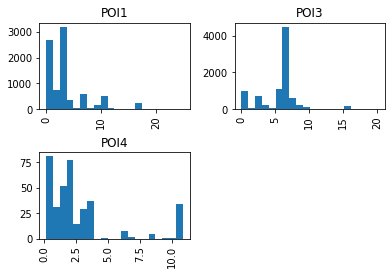

In [8]:
import networkx as nx
from networkx.algorithms.centrality import degree_centrality
network_data = (data_location_gdf_clipped[['_ID', 'POIID', 'distance']]
                .assign(distance=1.0/data_location_gdf_clipped['distance']))
G=nx.Graph()
G.add_nodes_from(data_pd['_ID'].unique(), bipartite=0)
G.add_nodes_from(poi_pd['POIID'].unique(), bipartite=1)
G.add_weighted_edges_from(network_data.to_numpy())
dc = degree_centrality(G)
print({key:val for key, val in dc.items() if key.startswith('POI')})
hist_data = data_location_gdf_clipped[['POIID', 'distance']]
hist_data.hist(by='POIID', bins=20)

# Extract feature for each POI with PCA
Principle component analysis (PCA) is a way to find how data distributed in high dimension.
For records of a POI, eigenvalues obtained by principle component analysis find directions where records spread the most.
If the records associate with a POI have higher eigenvalue, that means the records are less condensed. 
Assume a POI is better if its records are more condensed, then it's better for a POI to have lower mean-squared sum of eigenvalue.
Since we use eigenvalue that measures the spread of the data as the input to calculate score, it will be robust to outliers.

In [9]:
from sklearn.decomposition import PCA
pca_models = {}
for POIID in poi_pd['POIID'].to_numpy():
    pca_model = PCA(n_components=2)
    pca_model.fit(data_location_gdf_clipped
                  [data_location_gdf_clipped['POIID']==POIID]
                  [['Longitude', 'Latitude']].to_numpy())
    pca_models[POIID] = pca_model
    
pca_models_pd = (pd.DataFrame([(key, *val.singular_values_.tolist(), *val.explained_variance_ratio_) 
                                for key, val in pca_models.items()], 
                               columns=['POIID', 'var1', 'var2', 'normVar1', 'normVar2'])
                 .set_index('POIID'))

# Visualization of PCA
Below is the visualization of PCA. The ellipse roughly illustrate the distribution of the data. Each ellipse is draw based on the eigenvalues and eigen vectors obtained by performing PCA for each POI which is centered at mean of record positions. The green line and yellow line are directions of where data distribution varies the most. We can see it's not fitting POI4 since it's distribution is not that dondensed.

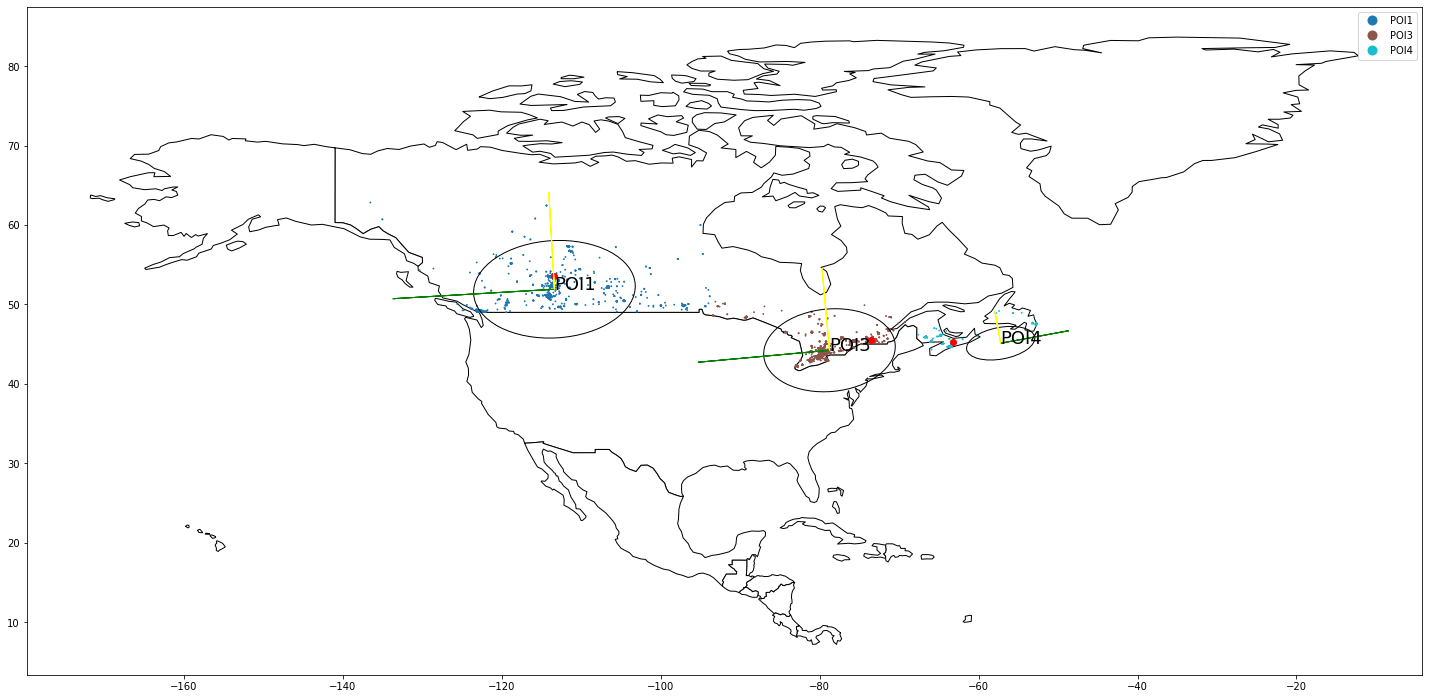

In [10]:
from matplotlib.patches import Ellipse

ax = world[world['continent']=='North America'].plot(color='white', edgecolor='black', figsize=(25,25))
data_location_gdf_clipped.plot(ax=ax, column='POIID', markersize=0.7, legend=True)
poi_gdf.plot(ax=ax, color='red')

for poi_id, x, y in poi_statistics_pd[['POIID', 'mean_long', 'mean_lat']].to_numpy():
    eig_vec = pca_models[poi_id].components_
    eig_val = np.sqrt(pca_models[poi_id].singular_values_)
    scaled_eng_vec = np.multiply(eig_vec.T, eig_val).T
    rad = eig_vec[0][1]/eig_vec[0][0]
    degree = np.degrees(np.arcsin(rad))
    ax.add_artist(Ellipse((x,y), *eig_val, degree, fill=False))
    ax.add_artist(plt.arrow(x,y, *scaled_eng_vec[0], color='green'))
    ax.add_artist(plt.arrow(x,y, *scaled_eng_vec[1], color='yellow'))
    ax.text(x, y, poi_id, fontsize=18)

## Extract time feature for each POI
Beside geographical information, temporal information is also important.
The time lapse between 2 consecutive records is a good indicator for the importance of POI.
If the POI has smaller time lapse between records that means the records associate with the POI is more frequent, we can say the poi is more important.

In [11]:
time_window = Window.partitionBy('POIID').orderBy('unix_time')
time_df = (data
           .select('POIID', 'unix_time')
           .withColumn('prev_unix_time', F.lag('unix_time').over(time_window))
           .withColumn('time_diff', F.col('unix_time')-F.col('prev_unix_time'))
           .groupBy('POIID')
           .agg(F.mean('time_diff').alias('mean_time_diff'),
                F.stddev('time_diff').alias('std_time_diff')))
time_pd = time_df.toPandas() 
time_pd

,POIID,mean_time_diff,std_time_diff
0,POI4,192.370892,219.948215
1,POI1,9.486245,10.990378
2,POI3,9.386281,11.441728


## Design function to output within range of [-10, 10]

Given the selected input, we'd like to have a function which output is bounded by -10 and 10. The scaled and shifted tanh function meets our need. By tuning the scaling factor, we can design the function for scoring poi given input.

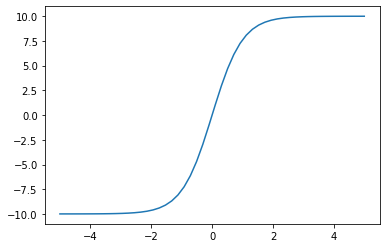

In [12]:
def tanh(x, x_scaling=1.0, y_scaling=1.0, shift=0.0):
    a = math.exp((x+shift)*x_scaling)
    b = math.exp(-(x+shift)*x_scaling)
    return y_scaling*(a-b)/(a+b)

def tanhnp(x, x_scaling=1.0, y_scaling=1.0, shift=0.0):
    a = np.exp((x+shift)*x_scaling)
    b = np.exp(-(x+shift)*x_scaling)
    return y_scaling*(a-b)/(a+b)
x = np.linspace(-5, 5)
y = tanhnp(x, 1.0, 10.0)
sns.lineplot(x,y)

## Scoring function

Three factors are chosen for the scoring for each POI, eigenvalues of PCA, variances of time lapse and total number of records.
- Eigenvalues of PCA the lower the better
- Mean of time lapse the lower the better
- Number of total records the higher the better
The input of the tanh function metioned before will be
$\frac{\alpha \times num\_records}{\sqrt{\sum {eigenval}^2}\times mean\_time\_interval}$
By tweaking the constant $\alpha$ we can score each POI within [-10, 10]

We can see POI3 has the highest score, since the number and desity of records is the highest but with the lowest lapse between records. POI1 is behind POI3 since it has less records and its records spreads more. POI4 get the negative score since its small amounts of records and sporadic distribution.

In [13]:
import math
def get_score_funct(scaling_factor):
    def score_func(var1, var2, time_mean, num_records):
        dist_var = math.sqrt((var1**2+var2**2))
        x = scaling_factor*num_records/dist_var/time_mean
        return tanh(x, 1.0, 10.0, -0.5)
    return score_func
score_func = get_score_funct(4.0)
scoring_pd = (pca_models_pd
              .join(poi_statistics[['POIID', 'num_records']].toPandas()
                    .set_index('POIID'))
              .join(time_pd.set_index('POIID')))
scoring_pd = scoring_pd.assign(score=scoring_pd.apply(lambda row: score_func(row['var1'], row['var2'], 
                                                             row['mean_time_diff'], 
                                                             row['num_records']), axis=1)).reset_index()
scoring_pd

,POIID,var1,var2,normVar1,normVar2,num_records,mean_time_diff,std_time_diff,score
0,POI4,75.675026,15.846471,0.957993,0.042007,427,192.370892,219.948215,-3.671839
1,POI1,414.631653,150.004196,0.884265,0.115735,8725,9.486245,10.990378,9.999997
2,POI3,275.554016,107.909355,0.867034,0.132966,8821,9.386281,11.441728,10.000000
